# Diff Losses Nsteps Test
Recrea el testbench `diff_losses_tb.cpp` en Python y compara la salida por software y por hardware.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from pynq import Overlay, allocate

In [12]:
import numpy as np
from scipy.ndimage import gaussian_filter


In [4]:
N = 64
steps = 361
DATA_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
def read_matrix(fn):
    data = np.loadtxt(fn, dtype=np.float32)
    m = (data[:,0] + 1j*data[:,1]).astype(np.complex64)
    return m.reshape(N, N, order='F')
phi_in = read_matrix(DATA_DIR / 'phi_in.dat')
golden = read_matrix(DATA_DIR / 'golden.dat')

In [5]:
Lx = 45e-6
Ly = 45e-6
dx = Lx / N
dy = Ly / N
dz = 1e-4
k = 7853981.6339
eps2 = 1e-24

def compute_b_vector(dp, dp1, dp2, off, x0):
    b = np.empty(N, dtype=np.complex64)
    b[0] = x0[0]*dp1 + x0[1]*off
    for i in range(1, N-1):
        b[i] = x0[i-1]*off + x0[i]*dp + x0[i+1]*off
    b[N-1] = x0[N-2]*off + x0[N-1]*dp2
    return b

def thomas_solver(dp, dp1, dp2, off, b):
    c_prime = np.empty(N, dtype=np.complex64)
    d_prime = np.empty(N, dtype=np.complex64)
    inv1 = 1.0 / dp1
    c_prime[0] = inv1 * off
    d_prime[0] = b[0] * inv1
    for i in range(1, N-1):
        denom = dp - c_prime[i-1]*off
        invd = 1.0 / denom
        c_prime[i] = invd * off
        d_prime[i] = (b[i] - d_prime[i-1]*off) * invd
    denom = dp2 - c_prime[N-2]*off
    invd = 1.0 / denom
    d_prime[N-1] = (b[N-1] - d_prime[N-2]*off) * invd
    x = np.empty(N, dtype=np.complex64)
    x[N-1] = d_prime[N-1]
    for i in range(N-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i]*x[i+1]
    return x

def adi_x(arr):
    out = np.empty_like(arr)
    ung = 1j * (dz / (4*k*dx*dx))
    neg2u = -2.0 * ung
    pos2u =  2.0 * ung
    for j in range(N):
        x0 = arr[:, j].copy()
        ratio0 = 1+0j if np.abs(x0[1]) < eps2 else x0[0]/x0[1]
        ratioN = 1+0j if np.abs(x0[N-2]) < eps2 else x0[N-1]/x0[N-2]
        dp_B  = neg2u + 1
        dp1_B = dp_B + ung*ratio0
        dp2_B = dp_B + ung*ratioN
        b = compute_b_vector(dp_B, dp1_B, dp2_B, ung, x0)
        dp_A  = pos2u + 1
        dp1_A = dp_A - ung*ratio0
        dp2_A = dp_A - ung*ratioN
        x = thomas_solver(dp_A, dp1_A, dp2_A, -ung, b)
        out[:, j] = x
    return out

def adi_y(arr):
    out = np.empty_like(arr)
    ung = 1j * (dz / (4*k*dy*dy))
    neg2u = -2.0 * ung
    pos2u =  2.0 * ung
    for i in range(N):
        x0 = arr[i, :].copy()
        ratio0 = 1+0j if np.abs(x0[1]) < eps2 else x0[0]/x0[1]
        ratioN = 1+0j if np.abs(x0[N-2]) < eps2 else x0[N-1]/x0[N-2]
        dp_B  = neg2u + 1
        dp1_B = dp_B + ung*ratio0
        dp2_B = dp_B + ung*ratioN
        b = compute_b_vector(dp_B, dp1_B, dp2_B, ung, x0)
        dp_A  = pos2u + 1
        dp1_A = dp_A - ung*ratio0
        dp2_A = dp_A - ung*ratioN
        x = thomas_solver(dp_A, dp1_A, dp2_A, -ung, b)
        out[i, :] = x
    return out

def diff_losses_sw(phi_in, steps):
    phi = phi_in.copy()
    tmp = np.empty_like(phi)
    for _ in range(steps):
        tmp = adi_x(phi)
        phi = adi_y(tmp)
    return phi

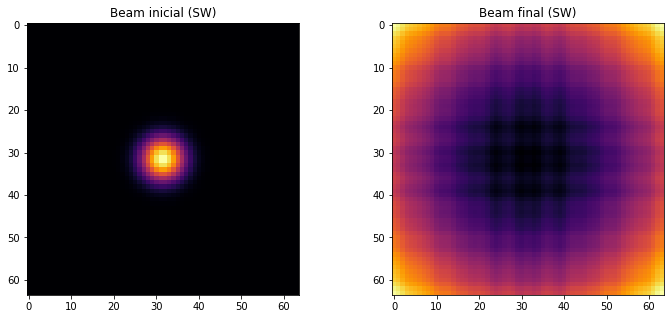

Software time: 261.6311 s
RMS vs golden: 3.264629e-06


In [6]:
start = time.perf_counter()
phi_sw = diff_losses_sw(phi_in, steps)
sw_time = time.perf_counter() - start
sw_err = np.sqrt(np.mean(np.abs(phi_sw - golden)**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(np.abs(phi_in)**2, cmap='inferno'); plt.title('Beam inicial (SW)')
plt.subplot(1,2,2); plt.imshow(np.abs(phi_sw)**2, cmap='inferno'); plt.title('Beam final (SW)')
plt.show()
print(f'Software time: {sw_time:.4f} s')
print(f'RMS vs golden: {sw_err:.6e}')

In [9]:
# --- Ejecución en hardware ---
ol = Overlay('full_propagation.bit')  # reemplace con ruta al bitstream
ip = ol.diff_losses_0
TOTAL = N * N
in_buffer = allocate(shape=(TOTAL,), dtype=np.complex64)
out_buffer = allocate(shape=(TOTAL,), dtype=np.complex64)
np.copyto(in_buffer, phi_in.reshape(TOTAL, order='F'))

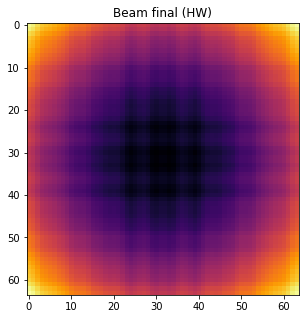

Hardware time: 1.5670 s
RMS HW vs SW: 3.719822e-06


In [10]:
ip.write(0x10, in_buffer.physical_address)
ip.write(0x1c, out_buffer.physical_address)
ip.write(0x28, steps)
t0 = time.perf_counter()
ip.write(0x00, 1)
while (ip.read(0x00) & 0x2) == 0:
    pass
hw_time = time.perf_counter() - t0
phi_hw = np.array(out_buffer).reshape(N, N, order='F')
plt.figure(figsize=(5,5))
plt.imshow(np.abs(phi_hw)**2, cmap='inferno'); plt.title('Beam final (HW)')
plt.show()
rms_hw = np.sqrt(np.mean(np.abs(phi_hw - phi_sw)**2))
print(f'Hardware time: {hw_time:.4f} s')
print(f'RMS HW vs SW: {rms_hw:.6e}')

In [13]:
# Genera la máscara de fase aleatoria
x = np.linspace(-Lx/2, Lx/2, N, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, N, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')
dx = x[1] - x[0]
dy = y[1] - y[0]
desviacion_fase = 0.2
correlacion_m = 5
theta = np.random.normal(0, desviacion_fase, size=(N, N))
theta = gaussian_filter(theta, sigma=correlacion_m)
mask = np.exp(1j * theta)


In [14]:
phi_sw_masked = phi_sw * mask
phi_hw_masked = phi_hw * mask


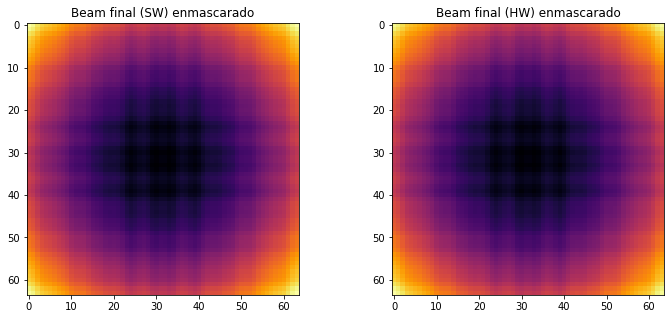

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(np.abs(phi_sw_masked)**2, cmap='inferno'); plt.title('Beam final (SW) enmascarado')
plt.subplot(1,2,2); plt.imshow(np.abs(phi_hw_masked)**2, cmap='inferno'); plt.title('Beam final (HW) enmascarado')
plt.show()


In [16]:
print(f" {7.7918/1.5670} x times acceleration")

 4.972431397574985 x times acceleration
